### Script for reading neuroglancer precomputed volume and storing as zarr or n5

In [1]:
import tensorstore as ts
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset_future = ts.open({
    "driver": "neuroglancer_precomputed",
    "kvstore": "s3://bossdb-open-data/kuan_phelps2020/drosophila_leg_75nm/190515_merged_fullres",
    # Use 500MB in-memory cache.
    "context": {
        "cache_pool": {
            "total_bytes_limit": 500_000_000
        }
    },
    "recheck_cached_data": "open",
})
dataset = dataset_future.result()

In [3]:
dataset

TensorStore({
  'context': {
    'aws_credentials': {
      'filename': '',
      'metadata_endpoint': '',
      'profile': '',
    },
    'cache_pool': {'total_bytes_limit': 500000000},
    'data_copy_concurrency': {},
    's3_request_concurrency': {},
    's3_request_retries': {},
  },
  'driver': 'neuroglancer_precomputed',
  'dtype': 'uint8',
  'kvstore': {
    'bucket': 'bossdb-open-data',
    'driver': 's3',
    'path': 'kuan_phelps2020/drosophila_leg_75nm/190515_merged_fullres/',
  },
  'multiscale_metadata': {'num_channels': 1, 'type': 'image'},
  'recheck_cached_data': 'open',
  'scale_index': 0,
  'scale_metadata': {
    'chunk_size': [512, 512, 16],
    'encoding': 'raw',
    'key': '75.0_75.0_75.0',
    'resolution': [75.0, 75.0, 75.0],
    'sharding': None,
    'size': [11776, 6144, 7856],
    'voxel_offset': [0, 0, 0],
  },
  'transform': {
    'input_exclusive_max': [11776, 6144, 7856, 1],
    'input_inclusive_min': [0, 0, 0, 0],
    'input_labels': ['x', 'y', 'z', 'chan

In [4]:
dataset_3d = dataset[ts.d['channel'][0]]
dataset_3d.domain

{ "x": [0, 11776), "y": [0, 6144), "z": [0, 7856) }

In [5]:
dataset_3d.shape

(11776, 6144, 7856)

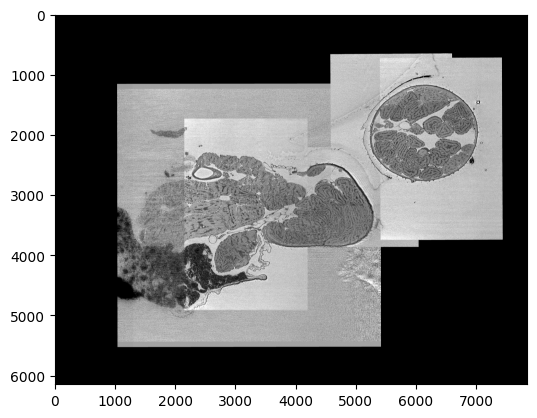

In [6]:
slice = dataset_3d[6301, :, :]
plt.imshow(slice, cmap='gray')

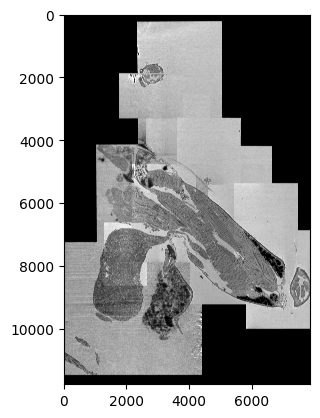

In [7]:
slice = dataset_3d[:, 3000, :]
plt.imshow(slice, cmap='gray')

In [5]:
zarr_out = ts.open({
    "driver": "zarr3",
    "kvstore": {
        "driver": "file",
        "path": "/home/katzw/image-conversion/data.zarr",
    },
    # "metadata": {
    #     "shape": [channel.shape[0], channel.shape[1], channel.shape[2]],
    #     "chunk_grid": {
    #         "name": "regular", 
    #         "configuration": {"chunk_shape": [160, 160, 160]}
    #     },
    #     "chunk_key_encoding": {"name": "default"},
    #     # "codecs": [
    #     #     {
    #     #         "name": "blosc", 
    #     #         "configuration": {"cname": "lz4", "clevel": 5}
    #     #     }
    #     # ],
    #     "data_type": "uint8"
    # },
    # "create": True,
    # "delete_existing": True
}).result()

In [9]:
n5_out = ts.open({
    'driver': 'n5',
    'kvstore': {
        'driver': 'file',
        'path': '/home/katzw/bossdb-convert/data.n5',
    },
    # 'metadata': {
    #     'compression': {
    #         'type': 'gzip'
    #     },
    #     'dataType': 'uint8',
    #     'dimensions': [11776, 6144, 7856],  # Could this be ZYX for n5? So [7856, 6144, 11776]?
    #     'blockSize': [256, 256, 256],
    # },
    # 'create': True,
    # 'delete_existing': True,
}).result()

In [14]:
dataset_3d.shape

(11776, 6144, 7856)

In [19]:
n5_out.shape

(11776, 6144, 7856)

In [ ]:
min()

In [20]:
chunk_size = (256, 256, 256)

async def write_chunks(src, array_out, chunk_size, start_indices=(0, 0, 0)):
    x_chunks, y_chunks, z_chunks = [range(start, dim, chunk) for start, dim, chunk in zip(start_indices, src.shape, chunk_size)]
    
    for z0 in z_chunks:
        for y0 in y_chunks:
            for x0 in x_chunks:
                z1 = min(z0 + chunk_size[2], src.shape[2])
                y1 = min(y0 + chunk_size[1], src.shape[1])
                x1 = min(x0 + chunk_size[0], src.shape[0])
                
                # Extract the chunk from the src
                chunk = src[x0:x1, y0:y1, z0:z1]
                
                # Write the chunk to array_out
                await array_out[x0:x1, y0:y1, z0:z1].write(chunk)
                print(f"wrote chunk xyz {x0}:{x1}, {y0}:{y1}, {z0}:{z1}")

In [21]:
start_indices = (5888, 0, 0)
await write_chunks(dataset_3d, n5_out, chunk_size, start_indices)

wrote chunk xyz 7680:7936, 0:256, 0:256
wrote chunk xyz 7936:8192, 0:256, 0:256
wrote chunk xyz 8192:8448, 0:256, 0:256
wrote chunk xyz 8448:8704, 0:256, 0:256
wrote chunk xyz 8704:8960, 0:256, 0:256
wrote chunk xyz 8960:9216, 0:256, 0:256
wrote chunk xyz 9216:9472, 0:256, 0:256
wrote chunk xyz 9472:9728, 0:256, 0:256
wrote chunk xyz 9728:9984, 0:256, 0:256
wrote chunk xyz 9984:10240, 0:256, 0:256
wrote chunk xyz 10240:10496, 0:256, 0:256
wrote chunk xyz 10496:10752, 0:256, 0:256
wrote chunk xyz 10752:11008, 0:256, 0:256
wrote chunk xyz 11008:11264, 0:256, 0:256
wrote chunk xyz 11264:11520, 0:256, 0:256
wrote chunk xyz 11520:11776, 0:256, 0:256
wrote chunk xyz 7680:7936, 256:512, 0:256
wrote chunk xyz 7936:8192, 256:512, 0:256
wrote chunk xyz 8192:8448, 256:512, 0:256
wrote chunk xyz 8448:8704, 256:512, 0:256
wrote chunk xyz 8704:8960, 256:512, 0:256
wrote chunk xyz 8960:9216, 256:512, 0:256
wrote chunk xyz 9216:9472, 256:512, 0:256
wrote chunk xyz 9472:9728, 256:512, 0:256
wrote chunk